In [75]:
from dotenv import load_dotenv
import os
import time
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
from Preprocessing.preprocessing_pipeline_final import preprocessing_pipeline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

load_dotenv()  # lädt .env automatisch
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")



In [76]:
# Standardmäßig werden alle Zeilen angezeigt, egal, wie viele es sind
pd.set_option("display.max_columns", None)

In [ ]:
# Baut den Prompt inkl. PS-Zahl und ruft das LLM auf
def call_llm(model_name, ps):
    # Diese Funktion nutzt die API von Google um sich gegen das LLM zu schalten. Prompt etc. ist unten zu sehen

    llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001", #
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                '''Du bist ein Experte für Automobilklassifikation. Deine Aufgabe ist es, Automodelle basierend auf ihrem Namen und ihrer PS-Zahl einem passenden Fahrzeugsegment zuzuordnen. Achte nicht nur auf den Modellnamen oder die Fahrzeugklasse, sondern berücksichtige auch die PS-Zahl bei deiner Entscheidung.

                    Die Segmente sind:

                    1. Kleinwagen – kleine Stadtautos
                    Wenn ein Fahrzeug typischerweise als Kleinwagen gilt, aber eine sehr hohe PS-Zahl (z. B. über 180 PS) hat, handelt es sich um eine besonders leistungsstarke Variante. Solche Fahrzeuge sollten stattdessen den Sportwagen zugeordnet werden.
                    Generell sollten Marken wie Porsche, BMW und Audi eher zu Sportwagen zugeordnet werden, außer beispielsweise kleine Modelle wie der A1 von Audi
                    2. Mittelklasse – normale Alltagsautos
                    Mittelklassefahrzeuge mit sehr hoher PS-Zahl (z. B. über 250 PS) sind leistungsstarke Varianten und sollten nicht der Standard-Mittelklasse zugeordnet werden. Stattdessen sind sie als Sportwagen oder, bei besonders hoher Leistung als Supersportwagen zu klassifizieren.
                    Varianten wie Porsche, BMW und Audi sollten möglicherweise auch in die Luxusklasse eingeordnet werden.
                    3. Geländewagen – große Fahrzeuge mit viel Platz
                    Wenn ein Geländewagen eine sehr hohe PS-Zahl (z. B. über 260 PS) hat, handelt es sich um einen Luxus Geländewagen
                    4. Sportwagen – sportliche Fahrzeuge mit viel PS
                    Wenn ein Fahrzeug als Sportwagen eingestuft werden könnte, aber eine sehr hohe PS-Zahl (z. B. über 480 PS) hat, gehört es in die Kategorie Supersportwagen.
                    5. Luxusklasse – hochwertige Fahrzeuge mit Premiumausstattung–
                    Hier gehören Marken wie Porsche, Audi, BMW rein.
                    6. Luxus Geländewagen – große Fahrzeuge mit viel Platz und luxuriöser Ausstattung
                    Beipsielsweise der Porsche Cayenne oder Range Rover, Land Rover usw
                    7. Supersportwagen – Fahrzeuge mit sehr viel Leistung und hoher Endgeschwindigkeit
                    

                    Beispiele:
                    
                    Input: smart forTwo mit 71 PS  
                    Output: Kleinwagen

                    Input: Mini John Cooper mit 231 PS  
                    Output: Sportwagen

                    Input: Volkswagen Golf mit 115 PS  
                    Output: Mittelklasse

                    Input: BMW X5 mit 231 PS  
                    Output: Geländewagen

                    Input: Land Rover Range Rover mit 351 PS  
                    Output: Luxus Geländewagen

                    Input: Porsche 911 mit 450 PS  
                    Output: Sportwagen

                    Input: BMW M4 mit 510 PS  
                    Output: Supersportwagen

                    Input: Bentley Mulsanne mit 512 PS  
                    Output: Luxusklasse

                    Input: Mercedes-Benz G 63 AMG mit 585 PS  
                    Output: Luxus Geländewagen

                    Input: Audi R8 mit 620 PS  
                    Output: Supersportwagen

                Gib mir als Output nur das Fahrzeugsegment aus.                             
                ''',
            ),
            ("human", "{input}"),
        ]
    )

    # 
    chain = prompt | llm
    input_text = f"{model_name} mit {int(ps)} PS"
    res = chain.invoke({"input": input_text})

    return res.content

# Führt das für alle Modell-PS-Kombis durch und speichert das Ergebnis im Dictionary
def use_llm_on_model_ps_list(model_ps_list):
    # Diese Funktion ruft die call_llm Funktion auf, um den Spalten Model,PS das Fahrzeugsegment zuzuordnen

    result = {}

    for model, ps in model_ps_list:
        result[(model, ps)] = call_llm(model, ps)

    return result

In [60]:
# Modul zur parallelen Verarbeitung 
# Max_Workers zu 15 geändert statt 5, ist kein Problem, vielleicht sogar Erhöhung?
import concurrent.futures

def use_llm_on_model_ps_parallel(model_ps_list, max_workers=15):
    result = {}

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_model = {
            executor.submit(call_llm, model, ps): (model, ps)
            for model, ps in model_ps_list
        }

        
        for future in concurrent.futures.as_completed(future_to_model):
            model_ps = future_to_model[future]
            try:
                result[model_ps] = future.result()
            except Exception as e:
                result[model_ps] = f"Error: {e}"

    return result

In [61]:
# Aufruf der Preprocessing Pipeline
X_train, X_test, y_train, y_test , X,y, categorical_features , numeric_features = preprocessing_pipeline()

In [62]:
# Fügt Features und Target zusammen, um wieder vollständigen Datensatz zu haben
df = pd.concat([X, y], axis=1)

In [63]:
# Erstellung einer Liste von eindeutigen Kombinationen aus Modellname und PS-Zahl
model_ps_list = df[['model', 'power_ps']].drop_duplicates().values.tolist()

In [64]:
model_ps_list

[['Alfa Romeo Giulietta', 170.0],
 ['Alfa Romeo Giulietta', 120.0],
 ['Alfa Romeo Giulietta', 235.0],
 ['Alfa Romeo Giulietta', 140.0],
 ['Alfa Romeo Giulietta', 105.0],
 ['Alfa Romeo Giulietta', 150.0],
 ['Alfa Romeo Giulietta', 241.0],
 ['Alfa Romeo Giulietta', 209.0],
 ['Alfa Romeo Giulietta', 175.0],
 ['Alfa Romeo Giulia', 179.0],
 ['Alfa Romeo Stelvio', 209.0],
 ['Alfa Romeo Stelvio', 280.0],
 ['Alfa Romeo Giulia', 209.0],
 ['Alfa Romeo Giulia', 200.0],
 ['Alfa Romeo Stelvio', 200.0],
 ['Alfa Romeo Giulia', 510.0],
 ['Alfa Romeo Giulia', 280.0],
 ['Alfa Romeo Giulia', 136.0],
 ['Alfa Romeo Stelvio', 179.0],
 ['Alfa Romeo Stelvio', 510.0],
 ['Alfa Romeo Stelvio', 190.0],
 ['Alfa Romeo Stelvio', 150.0],
 ['Alfa Romeo Stelvio', 160.0],
 ['Alfa Romeo Giulia', 150.0],
 ['Alfa Romeo Giulia', 160.0],
 ['Alfa Romeo Giulia', 201.0],
 ['Alfa Romeo Giulia', 190.0],
 ['Alfa Romeo Stelvio', 201.0],
 ['Audi A4', 90.0],
 ['Audi A4', 101.0],
 ['Audi A8', 299.0],
 ['Audi A3', 101.0],
 ['Audi TT', 

In [65]:
len(model_ps_list)

3792

In [66]:
# Filtert alle Alfa Romeo mit mehr als 250 PS und sortiert diese absteigend nach PS Zahl
df[(df['model'] == 'Alfa Romeo Stelvio') & (df['power_ps'] > 250)].sort_values(by = 'power_ps', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro
655,alfa-romeo,Alfa Romeo Stelvio,grey,2018,375.0,510.0,Automatic,Petrol,9.0,210.0,60167.0,Quadrifoglio Q4|BIANCO TROFEO|1.HAND,10,2018,False,False,quadrifoglio qbianco trofeohand,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,54770
642,alfa-romeo,Alfa Romeo Stelvio,blue,2018,375.0,510.0,Automatic,Petrol,9.0,210.0,39000.0,Quadrifoglio Q4,7,2018,False,False,quadrifoglio q,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,62900
711,alfa-romeo,Alfa Romeo Stelvio,blue,2019,375.0,510.0,Unknown,Petrol,9.8,227.0,7000.0,Quadrifoglio 2.9V6 510PS AT8-Q4,5,2019,False,False,quadrifoglio v ps atq,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,68900
739,alfa-romeo,Alfa Romeo Stelvio,grey,2019,375.0,510.0,Automatic,Petrol,11.5,261.0,83780.0,V6 2.9 Bi-Turbo AT8-Q4 Quadrifoglio XENON ACC ...,5,2019,False,False,v biturbo atq quadrifoglio xenon acc hks,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,49950
694,alfa-romeo,Alfa Romeo Stelvio,black,2018,375.0,510.0,Automatic,Petrol,10.3,210.0,60750.0,Quadrifoglio MY18 Quadrifoglio 2,6,2018,False,False,quadrifoglio my quadrifoglio,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,53900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,alfa-romeo,Alfa Romeo Stelvio,gold,2022,206.0,280.0,Automatic,Petrol,8.5,189.0,10.0,VELOCE - 2.0T - Q4 - ASSISTENZ - PREMIUM - 21'',7,2022,False,False,veloce t q assistenz premium,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,55940
1241,alfa-romeo,Alfa Romeo Stelvio,red,2023,206.0,280.0,Automatic,Petrol,7.3,167.0,5000.0,2.0 Veloce Turbo 16V Q4 +Leder/Navi/Keyless/e-...,2,2023,False,False,veloce turbo v q ledernavikeylessesitz,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,67990
1245,alfa-romeo,Alfa Romeo Stelvio,black,2023,206.0,280.0,Automatic,Petrol,8.8,202.0,15.0,Competizione 2.0 Turbo16V 280PS Face Lift,1,2023,False,False,competizione turbov ps face lift,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,68990
1247,alfa-romeo,Alfa Romeo Stelvio,black,2023,206.0,280.0,Automatic,Petrol,9.2,209.0,10.0,2.0 Turbo 16V AT8-Q4 Competizione NAVI RKAM LEDER,5,2023,False,False,turbo v atq competizione navi rkam leder,False,True,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,69570


In [67]:
# Klassifizierung jeder eindeutigen Modell-PS-Kombination über das LLM (parallel),
# Speicherung der Ergebnisse in einem Dictionary
# Hängt das zugehörige Fahrzeugsegment als neue Spalte segment_ps an den DataFrame an

segment_result = use_llm_on_model_ps_parallel(model_ps_list, max_workers=15)

df["segment_ps"] = df.apply(
    lambda row: segment_result.get((row["model"], row["power_ps"]), "unknown"),
    axis=1
)

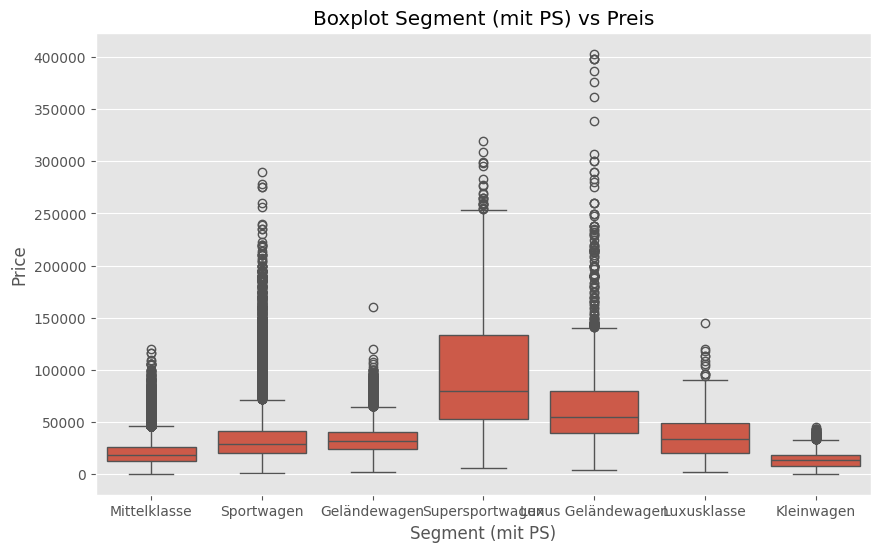

In [68]:
# Boxplot, wie Preise sich nach Segment verteilen - Erkennung von Outliern
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='segment_ps', y='price_in_euro')

plt.title("Boxplot Segment (mit PS) vs Preis")
plt.xlabel("Segment (mit PS)")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

In [ ]:
# Analyse der Segmente: Geländewagen
df[df['segment_ps'] == 'Geländewagen'][['model', 'power_ps', 'price_in_euro', 'year']].sort_values(by='price_in_euro', ascending=False)



,model,power_ps,price_in_euro,year
86147,Land Rover Range Rover,249.0,159900,2023
148292,Porsche Cayenne,245.0,119900,2011
83691,Land Rover Defender,150.0,109900,2016
149318,Porsche Cayenne,262.0,107600,2016
85940,Land Rover Defender,299.0,105880,2023
...,...,...,...,...
69752,Hyundai SANTA FE,145.0,2390,2006
25017,BMW X3,150.0,2000,2007
190715,Volkswagen Touareg,174.0,1999,2006
190297,Volkswagen Touareg,174.0,1990,2005


In [74]:
df[df['segment_ps'] == 'Geländewagen'][['model', 'power_ps', 'price_in_euro', 'year']]\
    .sort_values(by='price_in_euro', ascending=False)\
    .iloc[::5]


,model,power_ps,price_in_euro,year
86147,Land Rover Range Rover,249.0,159900,2023
149167,Porsche Cayenne,262.0,102400,2016
218969,Volkswagen Touareg,286.0,99690,2023
86013,Land Rover Defender,200.0,95900,2023
218703,Volkswagen Touareg,286.0,94490,2023
...,...,...,...,...
189332,Volkswagen Touareg,220.0,3950,2003
92402,Mercedes-Benz ML 350,245.0,3490,2003
189762,Volkswagen Touareg,174.0,3000,2004
69762,Hyundai SANTA FE,145.0,2450,2006


In [73]:
# Analyse der Segmente: Luxus Geländewagen
df[df['segment_ps'] == 'Supersportwagen'][['model', 'power_ps', 'price_in_euro', 'year']].sort_values(by='price_in_euro', ascending=False)


,model,power_ps,price_in_euro,year
150963,Porsche 992,510.0,319900,2021
151182,Porsche 992,650.0,308992,2022
151359,Porsche 992,650.0,299500,2023
151278,Porsche 992,650.0,297990,2022
151392,Porsche 992,650.0,295120,2023
...,...,...,...,...
4534,Audi S6,435.0,10800,2010
97346,Mercedes-Benz E 63 AMG,525.0,8999,2009
4537,Audi RS6,579.0,7470,2010
24534,BMW 335,500.0,7320,2007


In [ ]:
# Analyse der Segmente: Supersportwagen
df[df['segment_ps'] == 'Luxus Geländewagen'][['model', 'power_ps', 'price_in_euro', 'year']].sort_values(by='price_in_euro', ascending=False)


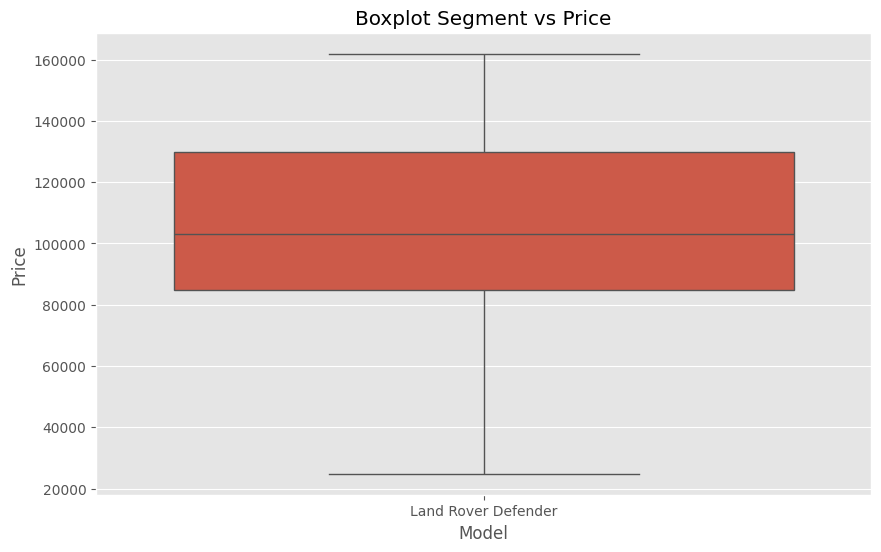

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['model'] == 'Land Rover Defender'], x='model', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Model")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

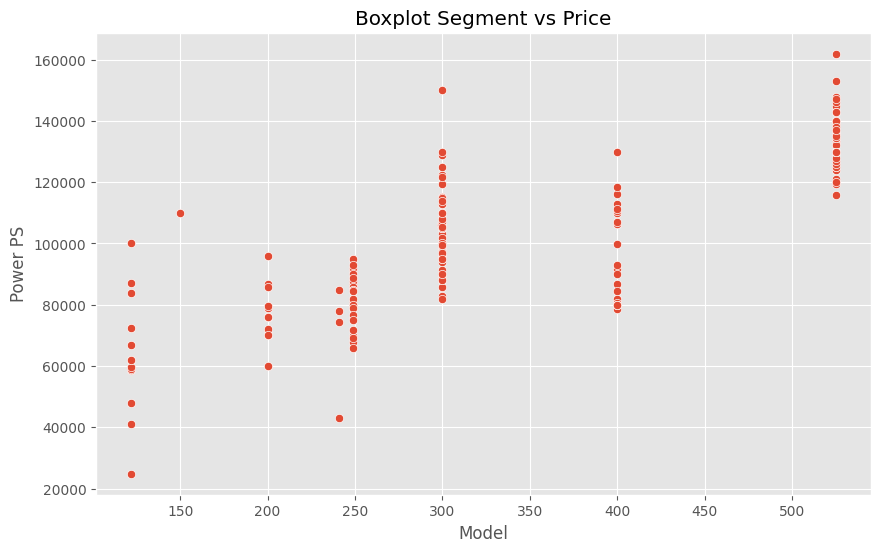

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['model'] == 'Land Rover Defender'], x='power_ps', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Power PS")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

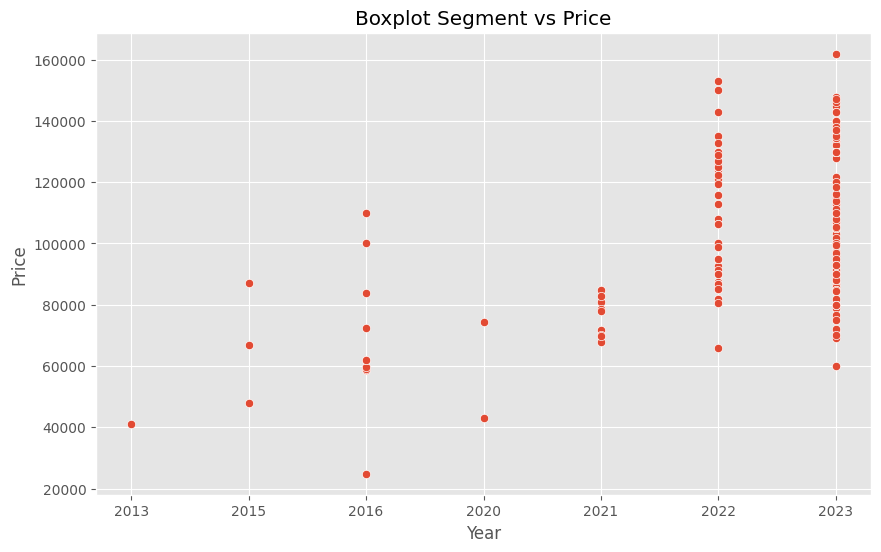

In [83]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['model'] == 'Land Rover Defender'], x='year', y='price_in_euro')

plt.title("Boxplot Segment vs Price")
plt.xlabel("Year")
plt.ylabel("Price")
#plt.tight_layout()
plt.show()

In [75]:
df[df['segment'] == 'Geländewagen'].sort_values(by = 'price_in_euro', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
150287,porsche,Porsche Cayenne,black,2018,324.0,441.0,Automatic,Petrol,9.2,209.0,67820.0,S ''21-Zoll Panorama Luftfederung BOSE'',7,2018,False,False,s zoll panorama luftfederung bose,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,145000,Geländewagen
151159,porsche,Porsche Cayenne,grey,2022,338.0,460.0,Automatic,Petrol,11.2,256.0,17000.0,"Coupe GTS SportDesign HUD SPORTABGAS 22""",1,2022,False,False,coupe gts sportdesign hud sportabgas,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,144950,Geländewagen
150772,porsche,Porsche Cayenne,silver,2019,404.0,549.0,Automatic,Petrol,11.4,261.0,58938.0,Turbo Clubleder HA-Lenkung LED 22-Zoll,2,2019,False,False,turbo clubleder halenkung led zoll,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,144900,Geländewagen
151197,porsche,Porsche Cayenne,red,2022,471.0,640.0,Automatic,Petrol,11.9,271.0,13122.0,Coupe GTS BOSE PANO TOTW TV SP.CHRONO,6,2022,False,False,coupe gts bose pano totw tv spchrono,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,144900,Geländewagen
151402,porsche,Porsche Cayenne,black,2023,338.0,460.0,Automatic,Petrol,13.2,308.0,19900.0,"GTS 22"";Matrix;360°; Standheiz.",5,2023,False,False,gts matrix standheiz,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,143890,Geländewagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124900,opel,Opel Zafira,grey,2005,92.0,125.0,Manual,Petrol,8.6,204.0,229484.0,"A 1,8 Alu KLimaautomatik Sitzheizung",4,2005,False,False,a alu klimaautomatik sitzheizung,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,590,Geländewagen
151420,renault,Renault Scenic,blue,2000,79.0,107.0,Manual,Petrol,7.4,175.0,149000.0,Megane 1.6 Kaleido,2,2000,False,False,megane kaleido,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,500,Geländewagen
151424,renault,Renault Scenic,blue,2001,79.0,107.0,Manual,Petrol,7.5,178.0,142407.0,1.6 16V Privilege,8,2001,False,False,v privilege,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,350,Geländewagen
151444,renault,Renault Scenic,blue,2001,79.0,107.0,Manual,Petrol,7.5,178.0,142401.0,1.6 16V Emotion,8,2001,False,False,v emotion,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,350,Geländewagen


In [52]:
df[df['model'] == 'Land Rover Defender'].sort_values(by = 'price_in_euro', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
86091,land-rover,Land Rover Defender,black,2023,386.0,525.0,Automatic,Petrol,12.9,290.0,42.0,110 V8 P525 Edition Meridian Panorama,2,2023,False,False,v p edition meridian panorama,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,161900,Geländewagen
85584,land-rover,Land Rover Defender,grey,2022,386.0,525.0,Automatic,Petrol,12.8,290.0,75.0,110 V8 P525 Carpathian Edition Tagzul.,5,2022,False,False,v p carpathian edition tagzul,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,152900,Geländewagen
85737,land-rover,Land Rover Defender,black,2022,221.0,300.0,Automatic,Diesel,7.6,247.0,8500.0,"130 D300X 22""8-Sitze AHK Standh.Black-P",10,2022,False,False,dx sitze ahk standhblackp,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,149900,Geländewagen
85961,land-rover,Land Rover Defender,grey,2023,386.0,525.0,Automatic,Petrol,14.8,334.0,11.0,V8 Carpathian Edition GREY/BLACK 2023,6,2023,False,False,v carpathian edition greyblack,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,147810,Geländewagen
85997,land-rover,Land Rover Defender,grey,2023,386.0,525.0,Automatic,Petrol,14.8,334.0,1000.0,110 P525 V8 Carpathian Edition,3,2023,False,False,p v carpathian edition,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,146990,Geländewagen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83661,land-rover,Land Rover Defender,black,2016,90.0,122.0,Manual,Diesel,10.0,265.0,35000.0,90 DPF Station Wagon SE AHK Klima LM,3,2016,False,False,dpf station wagon se ahk klima lm,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,58730,Geländewagen
83537,land-rover,Land Rover Defender,black,2015,90.0,122.0,Manual,Diesel,10.0,265.0,25800.0,3.0 TDV6 VOGUE*PAN*NAVi*LEDER*KAMERA,10,2015,False,False,tdv voguepannavilederkamera,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,47999,Geländewagen
85379,land-rover,Land Rover Defender,black,2020,177.0,241.0,Automatic,Diesel,7.6,199.0,29000.0,2.0 D240 S 110 **KAMERA LEDER 6-SITZE**,5,2020,False,False,d s kamera leder sitze,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,42900,Geländewagen
83404,land-rover,Land Rover Defender,black,2013,90.0,122.0,Manual,Diesel,10.0,265.0,25874.0,90 ORIGINAL PROJEKT - KAHN - CHELSEA,10,2013,False,False,original projekt kahn chelsea,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,40999,Geländewagen


In [ ]:
df[df['model'] == 'Audi R8'].sort_values(by = 'price_in_euro', ascending=False)

In [42]:
df[(df['brand'] == 'audi') & (df['power_ps'] < 250)].sort_values(by = 'power_ps', ascending=False)

,brand,model,color,year,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description,registration_month,registration_year,outlier_model_price,outlier_model_mileage,offer_description_cleaned,has_acc,has_additional_motortechnology,has_all_wheel_drive,has_assistence_systems,has_dab_radio,has_diesel_particel_feature,has_doubleclutch_transmission,has_heated_seats,has_leather_interior,has_navigation,has_panoramic_roof,has_sport_features,has_trailer_hitch,has_tuev,is_cabrio,is_combi,is_coupe,price_in_euro,segment
8689,audi,Audi Q3,red,2014,182.0,247.0,Manual,Petrol,7.3,173.0,150000.0,2.0 TFSI quattro (8UB) S.Line-Xenon-Navi,8,2014,False,False,tfsi quattro ub slinexenonnavi,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,16500,Geländewagen
7217,audi,Audi Q5,grey,2013,180.0,245.0,Automatic,Diesel,6.4,170.0,166000.0,"3.0 ""QUATTRO""| PANORAMA| KAMERA| eAHK| KEY-G|",1,2013,False,False,quattro panorama kamera eahk keyg,False,False,True,True,False,False,False,False,False,False,True,False,True,False,False,False,False,20549,Geländewagen
4928,audi,Audi A7,black,2010,180.0,245.0,Automatic,Diesel,5.9,156.0,238541.0,Sportback 3.0 TDI quattro TÜV 10/2023,10,2010,False,False,sportback tdi quattro tüv,False,True,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,13990,Luxusklasse
17168,audi,Audi TT,black,2019,180.0,245.0,Automatic,Petrol,7.0,161.0,25025.0,Coupe 45 TFSI QUATTRO*S-TRONIC*VIRTUAL,12,2019,False,False,coupe tfsi quattrostronicvirtual,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,38900,Sportwagen
9062,audi,Audi A6 allroad,black,2014,180.0,245.0,Automatic,Diesel,6.3,167.0,189870.0,Quattro 3.0 TDI*Massage*ACC*Standheiz,5,2014,False,False,quattro tdimassageaccstandheiz,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,26890,Mittelklasse
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12219,audi,Audi A1,silver,2016,60.0,82.0,Manual,Petrol,4.4,97.0,164989.0,Sportback Klima Sitzheiz. BT-Tel. M+S,5,2016,False,False,sportback klima sitzheiz bttel ms,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,10999,Kleinwagen
12218,audi,Audi A1,silver,2016,60.0,82.0,Manual,Petrol,4.4,98.0,69000.0,"Sportback S-Line,Xenon,Media-Paket,Sitzh,Pdc",12,2016,False,False,sportback slinexenonmediapaketsitzhpdc,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,15490,Kleinwagen
15164,audi,Audi A1,red,2018,60.0,82.0,Manual,Petrol,4.4,102.0,50000.0,design,6,2018,False,False,design,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,15300,Kleinwagen
13508,audi,Audi A1,black,2017,60.0,82.0,Manual,Petrol,4.4,97.0,35707.0,1.0 Lim. design KLIMA/XEN/NAVI/ALU,5,2017,False,False,lim design klimaxennavialu,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,15689,Kleinwagen


In [26]:
df['brand'].value_counts()

brand
volkswagen       23547
opel             15002
mercedes-benz    14637
audi             14382
ford             13494
bmw              11411
skoda            10756
seat              8942
renault           5669
hyundai           4388
peugeot           3931
kia               3789
mazda             3131
fiat              2732
porsche           2671
volvo             2465
mini              2330
land-rover        2293
toyota            2279
dacia             2142
citroen           2102
nissan            2097
jaguar            1021
smart              935
jeep               839
alfa-romeo         673
mitsubishi         329
honda              282
maserati           276
saab               101
Name: count, dtype: int64